In [ ]:
import math
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from matplotlib import pyplot as plt

sample_mapping = {
    "s1": "01",
    "s2": "02",
    "s3": "03",
    "s4": "04",
    "s5": "05",
    "s6": "06",
    "s7": "07",
    "s8": "08",
    "s9": "09",
    "s10": "10",
    "s11": "11",
    "s12", "12",
}


In [ ]:
sampling_round = 1
sample = 'Foroozan_Iraji'
sample_id = sample_mapping[sample]
file_name = ""
input_file = f'.txt'
session_type = "spk" if "spk" in input_file else "img"
final_output_file = f'/Project/data/cleaned_data/raw/{sample_id}_{session_type}_{int(math.ceil(sampling_round / 2))}.txt'


labels_df = pd.read_csv(f'/Project/data/{sample}/{sampling_round}/word_timings_fa.csv')

In [29]:
def remove_columns(input_file):
    columns_to_remove = ['CH9', 'CH19', 'CH27', 'CH30', 'CH61', 'ECG', 'VEP', 'EMG2']
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    column_names = lines[0].split()
    modified_lines = []
    counter = 0
    for line in lines:
        counter += 1
        columns = line.split()
        modified_columns = [col for i, col in enumerate(columns) if column_names[i] not in columns_to_remove]

        if counter % 10000 == 0:
            print(len(modified_columns), len(columns))

        modified_lines.append(modified_columns)
    return modified_lines

In [30]:
modified_lines = remove_columns(input_file)

57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65
57 65


In [41]:
def save_lines_to_file(lines, output_file):
    with open(output_file, 'w') as file:
        for line in lines:
            file.write(' '.join(line) + '\n')

In [269]:
modified_lines_without_header = modified_lines[1:]
save_lines_to_file(modified_lines_without_header, 'temp.txt')

In [270]:
import subprocess

In [ ]:
matlab_command = f"matlab -batch \"clean_eeg_data('/Project/data/temp.txt', '/Project/data/{sample}/{sampling_round}/')\""
subprocess.run(matlab_command, shell=True, check=True)

CompletedProcess(args='matlab -batch "clean_eeg_data(\'D:/university/8th_term/Project/data/temp.txt\', \'D:/university/8th_term/Project/data/Mohammad_Izadi/6/\')"', returncode=0)

In [12]:
import mne

In [52]:
real_ferquency = 1000
sampling_factor = 5

In [ ]:
raw_set = mne.io.read_raw_eeglab(f'/Project/data/{sample}/{sampling_round}/temp.set')

In [54]:
data = raw_set.get_data()

In [55]:
data.shape

(56, 536600)

In [56]:
raw_set.resample(sfreq=real_ferquency/sampling_factor)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,59 points
Good channels,56 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


In [57]:
new_data = raw_set.get_data()

In [58]:
new_data.shape

(56, 107320)

In [59]:
def make_epochs(start_point, epoch_size, data, labels_df):
    epochs = []
    labels = []
    for i in range(225):
        epochs.append(data[:, start_point: start_point + epoch_size])
        start_point += epoch_size
        labels.append(labels_df['Word'][i * 2 + 1])

    labels = LabelEncoder().fit_transform(labels)
    return np.array(epochs), labels

In [60]:
mne.set_log_level('WARNING')


In [87]:
def new_predictor(start, e_size, X, y):
    epochs, lables = make_epochs(start, e_size, X, y)
    X_train, X_test, y_train, y_test = train_test_split(epochs, lables, test_size=0.3, random_state=42, stratify=lables)
    csp_data_train = csp.fit_transform(X_train, y_train)
    csp_data_test = csp.transform(X_test)

    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.5, n_components=8)
    lda.fit(csp_data_train, y_train)

    y_pred = lda.predict(csp_data_test)
    y_pred_train = lda.predict(csp_data_train)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
    return accuracy, accuracy_train

In [79]:
new_predictor(3770, epoch_size, new_data, labels_df)

[3 7 4 1 4 2 6 6 4 4 3 8 6 3 7 7 3 3 2 0 0 8 5 6 7 3 5 2 7 5 6 0 3 1 0 2 4
 4 5 8 4 3 8 3 3 8 1 8 4 7 3 7 1 6 5 5 1 0 3 6 4 8 4 1 6 4 3 3]


0.1765

In [96]:
def predictor(start, e_size, X, y):
    epochs, lables = make_epochs(start, e_size, X, y)
    csp_data = csp.fit_transform(epochs, lables)
    X_train_csp, X_test_csp, y_train, y_test = train_test_split(csp_data, lables, test_size=0.3, random_state=42, stratify=lables)
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.5, n_components=8)
    lda.fit(X_train_csp, y_train)

    y_pred = lda.predict(X_test_csp)
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    return accuracy

In [99]:
import time

start_point = 0
step_size = 10
epoch_size = 2250 // sampling_factor

current_start_point = start_point
end_point = data.shape[1] - 225 * 2250
end_point //= sampling_factor

accuracies = []
starts = []
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)

last_time = time.time()

while current_start_point < end_point:
    accuracy = new_predictor(current_start_point, epoch_size, new_data, labels_df)
    print("Accuracy:", accuracy, "point:", current_start_point, "time passed:", time.time() - last_time)
    last_time = time.time()

    starts.append(current_start_point)
    accuracies.append(accuracy)
    
    current_start_point += step_size

Accuracy: (0.0882, 0.4777) point: 0 time passed: 2.0123398303985596
Accuracy: (0.0735, 0.5096) point: 10 time passed: 2.01653790473938
Accuracy: (0.0294, 0.4522) point: 20 time passed: 2.0213170051574707
Accuracy: (0.0735, 0.5096) point: 30 time passed: 1.9668805599212646
Accuracy: (0.0882, 0.5096) point: 40 time passed: 2.082714319229126
Accuracy: (0.0441, 0.5223) point: 50 time passed: 2.002220392227173
Accuracy: (0.0441, 0.5032) point: 60 time passed: 2.010485887527466
Accuracy: (0.1029, 0.414) point: 70 time passed: 2.11160945892334
Accuracy: (0.0735, 0.4268) point: 80 time passed: 2.117899179458618
Accuracy: (0.0294, 0.4841) point: 90 time passed: 2.0601837635040283
Accuracy: (0.0294, 0.414) point: 100 time passed: 2.0749876499176025
Accuracy: (0.0441, 0.4522) point: 110 time passed: 2.028047800064087
Accuracy: (0.0588, 0.4013) point: 120 time passed: 2.038987874984741
Accuracy: (0.0735, 0.4586) point: 130 time passed: 2.033017158508301
Accuracy: (0.0882, 0.4013) point: 140 time p

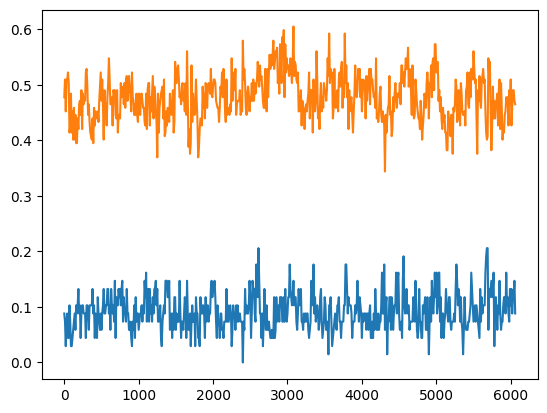

In [100]:
plt.plot(starts, accuracies)

In [96]:
assert 0 == 1

AssertionError: 

In [26]:
def print_triggers(lines):
    counter = 0
    triggers = []
    for index, line in enumerate(lines):
        if line[-1] != '0' and line[-1] != 'MARK':
            # print(index, line[-1])
            triggers.append((index, line[-1]))
            counter += 1
    print(f"Total number of trigges: {counter}")
    print(triggers)
    return triggers

In [27]:
import numpy as np

def get_noise(trigger_time):
    mean = 0
    scale = 60
    upper_bound = 100
    lower_bound = -upper_bound

    noise = np.random.normal(loc=mean, scale=scale, size=1)
    noise = np.clip(noise, lower_bound, upper_bound)
    return int(noise)

def get_marks(lines):
    counter = 0
    for line in lines:
        if line[-1] != '0':
            counter += 1
    return counter

def add_triggers(lines, from_row, until_tow, trigger_time):
    marks = get_marks(lines)
    if marks >= 15:
        raise Exception('Already modified')

    new_triggers_indices = []
    i = from_row
    while True:
        noise = get_noise(trigger_time)
        i += trigger_time 
        if i + trigger_time > until_tow:
            break
        new_triggers_indices.append(i + noise)

    for index in new_triggers_indices:
        lines[index][-1] = '3'

def remove_triggers(lines):
    for index in range(1, len(lines)):
        lines[index][-1] = '0'

In [31]:
modified_lines[0]

['F3',
 'F4',
 'P3',
 'AF3',
 'AFZ',
 'AF4',
 'P4',
 'F7',
 'F5',
 'F1',
 'FZ',
 'F2',
 'F6',
 'F8',
 'FT7',
 'FC5',
 'FC3',
 'FC1',
 'FCZ',
 'FC2',
 'FC4',
 'FC6',
 'FT8',
 'T7',
 'C5',
 'C3',
 'C1',
 'CZ',
 'C2',
 'C4',
 'C6',
 'T8',
 'TP7',
 'CP5',
 'CP3',
 'CP1',
 'CPZ',
 'CP2',
 'CP4',
 'CP6',
 'TP8',
 'P7',
 'P5',
 'P1',
 'PZ',
 'P2',
 'P6',
 'P8',
 'PO7',
 'PO3',
 'POZ',
 'PO4',
 'PO8',
 'O1',
 'OZ',
 'O2',
 'MARK']

In [32]:
remove_triggers(modified_lines)

In [33]:
a = print_triggers(modified_lines)

Total number of trigges: 0
[]


In [34]:
selected_start_point = 15181 - 2250
selected_end_point = selected_start_point + 227 * 2250
add_triggers(lines=modified_lines, from_row=selected_start_point, until_tow=selected_end_point, trigger_time=2250)

In [35]:
a = print_triggers(modified_lines)

Total number of trigges: 226
[(15123, '3'), (17428, '3'), (19656, '3'), (21944, '3'), (24221, '3'), (26396, '3'), (28649, '3'), (30900, '3'), (33134, '3'), (35443, '3'), (37728, '3'), (39990, '3'), (42222, '3'), (44451, '3'), (46661, '3'), (48934, '3'), (51195, '3'), (53410, '3'), (55630, '3'), (57898, '3'), (60106, '3'), (62457, '3'), (64622, '3'), (67031, '3'), (69235, '3'), (71482, '3'), (73676, '3'), (75963, '3'), (78281, '3'), (80378, '3'), (82699, '3'), (85031, '3'), (87252, '3'), (89437, '3'), (91650, '3'), (93911, '3'), (96255, '3'), (98439, '3'), (100614, '3'), (102849, '3'), (105103, '3'), (107437, '3'), (109687, '3'), (111831, '3'), (114168, '3'), (116422, '3'), (118581, '3'), (120927, '3'), (123210, '3'), (125360, '3'), (127701, '3'), (129899, '3'), (132281, '3'), (134339, '3'), (136737, '3'), (138943, '3'), (141179, '3'), (143442, '3'), (145657, '3'), (147880, '3'), (150281, '3'), (152473, '3'), (154669, '3'), (156961, '3'), (159130, '3'), (161407, '3'), (163650, '3'), (16

In [36]:
def get_first_trigger_index(lines):
    for index, line in enumerate(lines):
        if line[-1] != '0' and line[-1] != 'MARK':
            return index

def get_last_trigger_index(lines):
    for index, line in enumerate(lines[::-1]):
        if line[-1] != '0' and line[-1] != 'MARK':
            return len(lines) - index

def remove_lines_before_first_trigger_and_after_last_trigger(lines):
    threshold = 500
    first_index = get_first_trigger_index(lines)
    del lines[1: first_index - threshold]
    last_index = get_last_trigger_index(lines)
    del lines[last_index + 1 + threshold: len(lines)]
    return lines

In [37]:
modified_lines = remove_lines_before_first_trigger_and_after_last_trigger(modified_lines)

In [38]:
a = print_triggers(modified_lines)

Total number of trigges: 226
[(501, '3'), (2806, '3'), (5034, '3'), (7322, '3'), (9599, '3'), (11774, '3'), (14027, '3'), (16278, '3'), (18512, '3'), (20821, '3'), (23106, '3'), (25368, '3'), (27600, '3'), (29829, '3'), (32039, '3'), (34312, '3'), (36573, '3'), (38788, '3'), (41008, '3'), (43276, '3'), (45484, '3'), (47835, '3'), (50000, '3'), (52409, '3'), (54613, '3'), (56860, '3'), (59054, '3'), (61341, '3'), (63659, '3'), (65756, '3'), (68077, '3'), (70409, '3'), (72630, '3'), (74815, '3'), (77028, '3'), (79289, '3'), (81633, '3'), (83817, '3'), (85992, '3'), (88227, '3'), (90481, '3'), (92815, '3'), (95065, '3'), (97209, '3'), (99546, '3'), (101800, '3'), (103959, '3'), (106305, '3'), (108588, '3'), (110738, '3'), (113079, '3'), (115277, '3'), (117659, '3'), (119717, '3'), (122115, '3'), (124321, '3'), (126557, '3'), (128820, '3'), (131035, '3'), (133258, '3'), (135659, '3'), (137851, '3'), (140047, '3'), (142339, '3'), (144508, '3'), (146785, '3'), (149028, '3'), (151280, '3'), (

In [39]:
final_output_file

'D:/university/8th_term/Project/data/cleaned_data/raw/05_img_3.txt'

In [43]:
save_lines_to_file(modified_lines[1:], final_output_file)